# Pipeline 

In [1]:
%load_ext autoreload
%autoreload 2

from averitec import Datapoint
from evidence_generation import GptEvidenceGenerator, GptBatchedEvidenceGenerator, DynamicFewShotBatchedEvidenceGenerator
from classification import DefaultClassifier, HuggingfaceClassifier, AverageEnsembleClassifier, LogRegEnsembleClassifier
from retrieval import SimpleFaissRetriever, Retriever, MmrFaissRetriever, SubqueryRetriever
from pipeline import Pipeline, MockPipeline
import pickle
from labels import label2id, id2label
import numpy as np
from sklearn.metrics import classification_report
import random
from tqdm import tqdm
import htmldate
random.seed(111)

import json

## Pipeline test

In [2]:
split = "val"
path = "/mnt/data/factcheck/averimatec/"
with open(path + f"{split}.json") as f:
    dataset = json.load(f)
    for i in range(len(dataset)):
        dataset[i]["claim_id"] = i
        dataset[i]["split"] = split
    datapoints = [Datapoint.from_dict(d) for d in dataset]

In [3]:
datapoint = Datapoint.from_dict(dataset[150])
datapoint

Datapoint(claim='Images show Tanks & Troops  deploying inside USA & Canada', claim_id=150, claim_date='2023-06-16', claim_images=['67d0a15035531374f6dae467#CLAIM#0.jpg', '67d0a15035531374f6dae467#CLAIM#1.jpg', '67d0a15035531374f6dae467#CLAIM#2.jpg'], speaker='Hal Turner', original_claim_url='https://web.archive.org/web/20230617224616/https://halturnerradioshow.com/index.php/en/news-page/world/tanks-troops-deploying-inside-u-s-a-and-canada', reporting_source='halturnerradioshow.com', location_ISO_code='US', label='Refuted', metadata={'transcription': '', 'media_source': 'https://web.archive.org/web/20230618011405im_/https://halturnerradioshow.com/images/2023/06/17/Tank-Train-Montreal-06-17-2023_large.jpg,https://web.archive.org/web/20230618011405im_/https://halturnerradioshow.com/images/2023/06/17/MilitaryConvoyOnFreeway-in-LA-CA.jpg,,https://web.archive.org/web/20230618011405im_/https://halturnerradioshow.com/images/2023/06/17/MilitaryConvoyOnFreeway-in-LA-CA.jpg', 'claim_types': ['Med

In [4]:
print(datapoint.speaker)

Hal Turner


In [25]:
# retriever = SimpleFaissRetriever(path="/mnt/data/factcheck/averitec-data/data_store/vecstore/dev/6k")
retriever = MmrFaissRetriever(path=f"/mnt/data/factcheck/averimatec/vector_store/{split}/text/2k_mxbai",k=6, fetch_k=24)
# retriever = MmrFaissRetriever(path=f"/mnt/data/factcheck/averitec-data/data_store/vecstore/{split}/2k")
retrieval_result = retriever(datapoint)
retrieval_result

RetrievalResult(documents=[Document(id='183e25ce-02d3-4b08-8511-f1da10c972ff', metadata={'url': 'https://www.army.mil/article/169006/us_uk_forces_join_canada_armys_largest_military_exercise', 'context_before': 'In the grand scheme, Maple Resolve strengthens the bonds between these three allies and provides a glimpse into the future of military conflict. Wars of the future will continue to involve the collaboration of multiple nations - no one fights alone anymore. A key element in this joint exercise is the exchange of aviation assets. This particular night has Canadian piloted CH-47 Chinooks and U.S. manned UH-60 Black Hawk helicopters. They will be working together to transport Canadian infantryman from CFB Cold Lake to attack nearby objectives. At these sites the Canadians will fight the opposing force - played by the British military. Outside a massive jet hangar stands an equally large man named Maj. Cole Petersen. An infantryman hailing from Cornell, British Columbia, he is the D

In [26]:
retrieval_result.images

[[{'url': 'https://www.wranglerforum.com/threads/trickle-charger-mounting-position.2449945/page-2',
   'imageUrl': 'https://www.wranglerforum.com/attachments/20220612_122537-jpg.4564419/?auto=webp&fit=bounds&format=pjgp&height=1920&optimize=high&width=1920',
   'title': 'Trickle charger mounting position | Page 2 | Jeep Wrangler Forum',
   'thumbnailUrl': 'https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcQsQvwcvv_wJRUDnT60Nr4dgPP4dVd0ahlJeroQGDQmAuYDESUB',
   'content': '[![Jeep Wrangler Forum banner](https://images.platforum.cloud/banners/wranglerforum_com_banner_2880w.jpg?auto=webp&fit=bounds&format=pjgp&optimize=high&quality=50)](https://www.wranglerforum.com/)\n\nMenu\n\n\n[Log in](https://www.wranglerforum.com/login/)\n\n* * *\n\n[Sign up](https://www.wranglerforum.com/register/)\n\n* * *\n\n- [Home](https://www.wranglerforum.com/)\n- [Forums](https://www.wranglerforum.com/forums/)\n- [Model Specific Jeep Discussions](https://www.wranglerforum.com/forums/#model-specific-jeep-

In [22]:
retriever.get_ris_results(datapoint, max_per_image=7, max_images=10)

[[{'url': 'https://www.wranglerforum.com/threads/trickle-charger-mounting-position.2449945/page-2',
   'imageUrl': 'https://www.wranglerforum.com/attachments/20220612_122537-jpg.4564419/?auto=webp&fit=bounds&format=pjgp&height=1920&optimize=high&width=1920',
   'title': 'Trickle charger mounting position | Page 2 | Jeep Wrangler Forum',
   'thumbnailUrl': 'https://encrypted-tbn1.gstatic.com/images?q=tbn:ANd9GcQsQvwcvv_wJRUDnT60Nr4dgPP4dVd0ahlJeroQGDQmAuYDESUB',
   'content': '[![Jeep Wrangler Forum banner](https://images.platforum.cloud/banners/wranglerforum_com_banner_2880w.jpg?auto=webp&fit=bounds&format=pjgp&optimize=high&quality=50)](https://www.wranglerforum.com/)\n\nMenu\n\n\n[Log in](https://www.wranglerforum.com/login/)\n\n* * *\n\n[Sign up](https://www.wranglerforum.com/register/)\n\n* * *\n\n- [Home](https://www.wranglerforum.com/)\n- [Forums](https://www.wranglerforum.com/forums/)\n- [Model Specific Jeep Discussions](https://www.wranglerforum.com/forums/#model-specific-jeep-

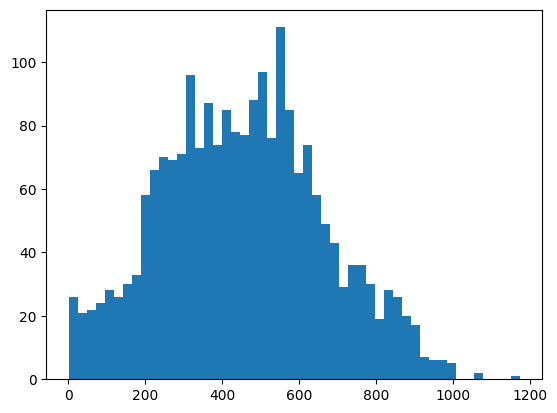

In [19]:
# load /mnt/personal/ullriher/aic_averimatec/logs/ris_results/pretty/val.json


with open("/mnt/personal/ullriher/aic_averimatec/logs/ris_results/pretty/val.json") as f:
    ris_payload = json.load(f)
content_pool = []
for entries in ris_payload.values():
    for entry in entries.values():
        for result in entry:
            if "content" in result:
                result["content"] = result["content"][:6000]
                content_pool.append(result["content"])
            if result["page_date"]=="2000-01-01":
                result["remove"] = True
# remove all entries with remove == True and preserve structure
for entries in ris_payload.values():
    for entry in entries.values():
        entry[:] = [result for result in entry if not result.get("remove", False)]
# save back
with open("/mnt/personal/ullriher/aic_averimatec/logs/ris_results/pretty/val_clean.json", "w") as f:
    json.dump(ris_payload, f, indent=4)

#hist content lengths
lengths = [len(content.split()) for content in content_pool]
import matplotlib.pyplot as plt
plt.hist(lengths, bins=50)
plt.show()

In [54]:
from openai import OpenAI
from pathlib import Path


client = OpenAI()
IMAGE_BASE_URL = f"https://fcheck.fel.cvut.cz/images/averimatec"
user_message_content = [
    {"type": "text", "text": datapoint.claim},
]

for i, img in enumerate(datapoint.claim_images):
    user_message_content.append(
        {
            "type": "image_url",
            "image_url": {
                "url": f"{IMAGE_BASE_URL}/{img}".replace("#", "_"),
            },
        }
    )

response = client.chat.completions.create(
    model="gpt-5.1",
    messages=[
        {"role": "system", "content": "You are an expert image-text claim verifier, is this claim true?"},
        {
            "role": "user",
            "content": user_message_content
        }
    ]
)

print(response.choices[0])

Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The claim is false.\n\nThese circulating photos are not real images from Hobby Lobby. They originate from a digital art project in which an artist composited “demonic”-looking statues into photos of a Hobby Lobby store. Fact‑checking outlets (including Snopes and others) confirmed that:\n\n- The statues were 3D models added with image‑editing software.\n- Hobby Lobby does not and did not sell these large horned or winged “demonic” statues.\n\nSo the photos are manipulated, and they do not show actual products for sale at Hobby Lobby.', refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))


In [56]:
user_message_content

[{'type': 'text',
  'text': 'Photos show that the craft store chain Hobby Lobby is selling demonic statues. '},
 {'type': 'image_url',
  'image_url': {'url': 'https://fcheck.fel.cvut.cz/images/averimatec/6787dee1e2f02e5f4981b14e_CLAIM_0.jpg'}},
 {'type': 'image_url',
  'image_url': {'url': 'https://fcheck.fel.cvut.cz/images/averimatec/6787dee1e2f02e5f4981b14e_CLAIM_1.jpg'}},
 {'type': 'image_url',
  'image_url': {'url': 'https://fcheck.fel.cvut.cz/images/averimatec/6787dee1e2f02e5f4981b14e_CLAIM_2.jpg'}},
 {'type': 'image_url',
  'image_url': {'url': 'https://fcheck.fel.cvut.cz/images/averimatec/6787dee1e2f02e5f4981b14e_CLAIM_3.jpg'}}]

In [57]:
datapoint.claim_images

['6787dee1e2f02e5f4981b14e#CLAIM#0.jpg',
 '6787dee1e2f02e5f4981b14e#CLAIM#1.jpg',
 '6787dee1e2f02e5f4981b14e#CLAIM#2.jpg',
 '6787dee1e2f02e5f4981b14e#CLAIM#3.jpg']

In [ ]:
#display images
from IPython.display import Image, display
for img_url in datapoint.claim_images:
    display(Image("/mnt/data/factcheck/averimatec/images/"+img_url))

In [33]:
datapoint = Datapoint.from_dict(dataset[2])
datapoint.claim, datapoint.claim_date, datapoint.speaker

('Photos show that the craft store chain Hobby Lobby is selling demonic statues. ',
 '2023-06-13',
 'Carousel Studios')

In [40]:
print(
    json.dumps(
        {
            "question": datapoint.claim,
            "speaker": datapoint.speaker,
            "date": datapoint.claim_date,
            "medium": datapoint.reporting_source,
        },
        indent=2,
    )
)

{
  "question": "Photos show that the craft store chain Hobby Lobby is selling demonic statues. ",
  "speaker": "Carousel Studios",
  "date": "2023-06-13",
  "medium": "Facebook "
}


In [41]:
from classification import DefaultClassifier, HuggingfaceClassifier, AverageEnsembleClassifier, LogRegEnsembleClassifier, RandomForestClassifier, NoTiebreakClassifier

# target = path + "data_store/vecstore/test/2k"
PIPELINE_NAME = "mmr+gpt51-dfewshot-atype"
classifier = NoTiebreakClassifier()  # DefaultClassifier()
if False:
    pipeline = MockPipeline(
        dumps=f"/mnt/data/factcheck/averitec-data/data_store/submissions/{split}_mmr+gpt4o-dfewshot-tiebrk-atype.pkl",
        classifier=NoTiebreakClassifier()
    )
else:
    pipeline = Pipeline(
        #dumps = "/mnt/data/factcheck/averitec-data/data_store/submissions/dev_mmr+gpt4o-dfewshot.pkl",
        #SubqueryRetriever(retriever),
        retriever,
        evidence_generator=DynamicFewShotBatchedEvidenceGenerator(), 
        classifier=classifier
    )

In [43]:
demo_result =pipeline(datapoint)
demo_result.retrieval_result

RetrievalResult(documents=[Document(id='861f38b0-51e0-4a19-8c03-eba4763cb47a', metadata={'url': 'https://www.bloomberg.com/profile/company/3043419Z:US', 'context_before': '', 'context_after': ''}, page_content='Hobby Lobby Stores Inc Hobby Lobby Stores, Inc. retails arts and craft products. The Company offers greeting cards, party crafts, fabric, floral, frames, hobby items, home accent, jewelry, needles, paper crafting, seasonal items, wearables, decorations, and wedding products. '), Document(id='913d0dfe-8ddb-415b-84e5-2a5ea97bd308', metadata={'url': 'https://www.themarysue.com/the-hobby-lobby-controversy-explained/', 'context_before': 'Perhaps the most baffling controversy of all came in 2015, when the Federal government investigated Hobby Lobby for smuggling artifacts out of a war-torn Iraq. There’s a whole Wikipedia page dedicated to it! The family smuggled a vast number of artifacts dating back to Biblical times with the intention of displaying them at the Museum of the Bible in

In [ ]:
submission = []
dump = []

for dp in tqdm(datapoints):
    pipeline_result = pipeline(dp)
    submission.append(pipeline_result.to_submission())
    dump.append(pipeline_result)
with open(f"{path}submissions/{split}_{PIPELINE_NAME}.json", "w") as f:
    json.dump(submission, f, indent=4)
with open(f"{path}submissions/{split}_{PIPELINE_NAME}.pkl", "wb") as f:
    pickle.dump(dump, f)

In [17]:
files = pipeline.evidence_generator.get_batch_files(path=f"/mnt/data/factcheck/averitec-data/data_store/batch_jobs/{split}_{PIPELINE_NAME}", batch_size=90)

In [18]:
files

[]

In [ ]:
batch_results = pipeline.evidence_generator.submit_and_await_batches(files, f"/mnt/data/factcheck/averitec-data/data_store/batch_jobs/{split}_{PIPELINE_NAME}/output.jsonl")

In [ ]:
new_dump = []
pipeline.evidence_generator.fallback_gpt_generator.client.temperature = .5
for pipeline_result, batch_result in zip(dump[:len(batch_results)], batch_results):
    new_result = pipeline.evidence_generator.update_pipeline_result(pipeline_result, batch_result, pipeline.classifier)
    new_dump.append(new_result)


In [ ]:
(
    new_dump[1],
    new_dump[1].evidence_generation_result,
    new_dump[1].classification_result
)

In [ ]:
with open(f"/mnt/data/factcheck/averitec-data/data_store/submissions/{split}_{PIPELINE_NAME}.json", "w") as f:
    json.dump([d.to_submission() for d in new_dump], f, indent=4)
with open(f"/mnt/data/factcheck/averitec-data/data_store/submissions/{split}_{PIPELINE_NAME}.pkl", "wb") as f:
    pickle.dump(new_dump, f)

In [32]:
print(f"{split}_{PIPELINE_NAME}")
%run src/prediction/evaluate_veracity.py --label_file /mnt/data/factcheck/averitec-data/data/dev.json --prediction_file /mnt/data/factcheck/averitec-data/data_store/submissions/{split}_{PIPELINE_NAME}.json

dev_mmr+gpt4o-dfewshot-atype
Question-only score (HU-meteor):             0.4566753100185953
Question-answer score (HU-meteor):           0.28764311409757226
Veracity F1 scores:
 * Supported:                                0.7252747252747253
 * Refuted:                                  0.8217821782178217
 * Not Enough Evidence:                      0.23684210526315788
 * Conflicting Evidence/Cherrypicking:       0.044444444444444446
 * macro:                                    0.45708586330003736
 * acc:                                      0.716
--------------------
AVeriTeC scores:
 * Veracity scores (meteor @ 0.1):           0.696
 * Veracity scores (meteor @ 0.2):           0.546
 * Veracity scores (meteor @ 0.25):          0.418
 * Veracity scores (meteor @ 0.3):           0.3
 * Veracity scores (meteor @ 0.4):           0.136
 * Veracity scores (meteor @ 0.5):           0.052
--------------------
AVeriTeC scores by type @ 0.25:
 * Veracity scores (Event/Property Claim):   0.20766

In [7]:
print(f"{split}_{PIPELINE_NAME}")
%run src/prediction/evaluate_veracity.py --label_file /mnt/data/factcheck/averitec-data/data/dev.json --prediction_file /mnt/data/factcheck/averitec-data/data_store/submissions/{split}_{PIPELINE_NAME}.json

dev_mmr+gpt4o-dfewshot-tiebrk-atype
Question-only score (HU-meteor):             0.4566753100185953
Question-answer score (HU-meteor):           0.2878181626887146
Veracity F1 scores:
 * Supported:                                0.7368421052631579
 * Refuted:                                  0.813953488372093
 * Not Enough Evidence:                      0.2222222222222222
 * Conflicting Evidence/Cherrypicking:       0.0784313725490196
 * macro:                                    0.46286229710162313
 * acc:                                      0.708
--------------------
AVeriTeC scores:
 * Veracity scores (meteor @ 0.1):           0.688
 * Veracity scores (meteor @ 0.2):           0.54
 * Veracity scores (meteor @ 0.25):          0.414
 * Veracity scores (meteor @ 0.3):           0.292
 * Veracity scores (meteor @ 0.4):           0.132
 * Veracity scores (meteor @ 0.5):           0.052
--------------------
AVeriTeC scores by type @ 0.25:
 * Veracity scores (Event/Property Claim):   0.20

## collapsible begin

In [ ]:
from IPython.display import display, Markdown, Latex

In [ ]:
knn_retrieval_result = retriever(datapoint)
display(Markdown("### 🗯️ " + datapoint.claim))
display(Markdown("*Retrieved by knn*\n\n"))
# sample 3
for r in knn_retrieval_result:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content[:256]}"))

In [ ]:
from retrieval import MmrFaissRetriever

mmr_retriever = MmrFaissRetriever(retriever.path)
mmr_retrieval_result = mmr_retriever(datapoint)
display(Markdown("### 🗯️ " + datapoint.claim))
display(Markdown("*Retrieved by MMR*\n\n"))
# sample 3
for r in mmr_retrieval_result:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n{r.page_content[:256]}"))

In [ ]:
subquery_retriever = SubqueryRetriever(retriever)
subquery_retrieval_result = subquery_retriever(datapoint)
display(Markdown("### 🗯️ " + datapoint.claim))
display(Markdown("*Retrieved by subqueries*\n\n"))
# sample 3
for r in subquery_retrieval_result:
    newline = "\n"
    display(Markdown(f"**{r.metadata['url']}**\n\n*{';'.join(r.metadata['queries'])}*\n\n{r.page_content[:256]}"))

In [ ]:
subquery_retrieval_result.metadata

## Collapsible section end

In [ ]:
evidence_generator = GptBatchedEvidenceGenerator("gpt-4o")
evidence_generation_result = evidence_generator(datapoint, retrieval_result)
evidence_generation_result

In [ ]:
evidence_generation_result.metadata["suggested_label"]

In [ ]:
datapoint.label

In [ ]:
classifier = DefaultClassifier()
classification_result = classifier(datapoint, evidence_generation_result, retrieval_result)
str(classification_result), classification_result

In [ ]:
datapoint2 = Datapoint.from_dict(dataset[16])
pipeline = Pipeline(retriever, evidence_generator, classifier)
pipeline_result = pipeline(datapoint2)
pipeline_result

In [ ]:
str(pipeline_result.classification_result), datapoint2.label

In [ ]:
pipeline_result.to_submission()

In [ ]:
# pickle dump pipeline result
import pickle
with open('data/pipeline_result.pkl', 'wb') as f:
    pickle.dump(pipeline_result, f)

In [ ]:
%run src/prediction/evaluate_veracity.py --label_file /mnt/data/factcheck/averitec-data/data/dev.json --prediction_file /mnt/data/factcheck/averitec-data/data_store/submission_dev_avg_clf.json

In [10]:
import json, os
# crawl /mnt/data/factcheck/averitec-data/data_store/batch_jobs and each time you find gpt4o in folder name and "output" in filename, load the file and add its line count to line_counts
line_counts = []
for root, dirs, files in os.walk("/mnt/data/factcheck/averitec-data/data_store/batch_jobs"):
    #print(root, files)
    if "gpt4o" in root:
        for f in files:
            if "output" in f:
                print(os.path.join(root,f))
                with open(os.path.join(root,f)) as f:
                    line_counts.append(len(f.readlines()))
            

/mnt/data/factcheck/averitec-data/data_store/batch_jobs/dev_subquery+gpt4o-dfewshot/output.jsonl
/mnt/data/factcheck/averitec-data/data_store/batch_jobs/dev_mmr+gpt4o-dfewshot-gpttiebreaking/output.jsonl
/mnt/data/factcheck/averitec-data/data_store/batch_jobs/dev_mmr+gpt4o-dfewshot-gpttiebreaking/output_old5.jsonl
/mnt/data/factcheck/averitec-data/data_store/batch_jobs/dev_mmr+gpt4o-dfewshot-gpttiebreaking/output_old.jsonl
/mnt/data/factcheck/averitec-data/data_store/batch_jobs/test_mmr+gpt4o-dfewshot-tiebrk-atype/output.jsonl
/mnt/data/factcheck/averitec-data/data_store/batch_jobs/dev_simple+gpt4o/output.jsonl
/mnt/data/factcheck/averitec-data/data_store/batch_jobs/dev_subquery+gpt4o/output.jsonl
/mnt/data/factcheck/averitec-data/data_store/batch_jobs/dev_mmr+gpt4o-dfewshot-gpttie-10ev/output.jsonl
/mnt/data/factcheck/averitec-data/data_store/batch_jobs/test_mmr+gpt4o-dfewshot/output.jsonl
/mnt/data/factcheck/averitec-data/data_store/batch_jobs/dev_mmr+gpt4o-dfewshot-tiebrk-atype/outp

In [11]:
line_counts

[500, 500, 5, 5, 2215, 100, 500, 500, 2215, 500, 500, 500, 500]

In [12]:
()/sum(line_counts)

8540